<a href="https://colab.research.google.com/github/spexdj/Data_Science_II_Machine_Learning/blob/main/EntrenamientoyOptimizaci%C3%B3n_ProyectoFinal_Licastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Impacto del Descuento en las Ventas Totales - ML
### 1. Abstracto: Motivación y Audiencia
En este análisis, buscamos responder si los descuentos ofrecidos en una tienda tienen un impacto significativo sobre las ventas totales.
Este trabajo será de interés para equipos de marketing, finanzas y operaciones, que desean optimizar promociones sin sacrificar rentabilidad.


### 2. Formulación del problema como ML
**Problema:** ¿Cuánto influyen los descuentos aplicados sobre el monto de venta total?

**Tipo de problema:** Regresión supervisada (predictiva)

**Variable objetivo:** `Sales.Total`
**Variable clave explicativa:** `Discount`


In [40]:
# 3. Importación de librerías y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
# Carga del dataset desde URL (puede reemplazarse con carga local)
url = "https://raw.githubusercontent.com/spexdj/Data_Science_II_Machine_Learning/refs/heads/main/superstore3.csv"
df = pd.read_csv(url, encoding='latin1', on_bad_lines='skip')

### 3. Breve Análisis Exploratorio de Datos (EDA)

In [42]:
# EDA breve
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("\nValores nulos:\n", df.isnull().sum())

Shape: (51290, 26)
Customer.ID         object
Customer.Name       object
Category            object
City                object
Country             object
Discount            object
Market              object
Order.Date          object
Order.Time          object
Order.ID            object
Order.Priority      object
Product.ID          object
Product.Name        object
Sales.Price        float64
Quantity             int64
Region              object
ItemsSale.Count      int64
Sales.Total         object
Segment             object
Ship.Date           object
Ship_Time           object
Ship.Mode           object
Shipping.Cost      float64
State               object
Sub.Category        object
Year                 int64
dtype: object
        Sales.Price      Quantity  ItemsSale.Count  Shipping.Cost  \
count  51290.000000  51290.000000     51290.000000   51290.000000   
mean      28.610982      3.476545       246.498440      26.375818   
std      174.340972      2.278766       487.567175      57

In [43]:
# Limpieza y conversión de datos necesarios para el análisis
# Convertimos 'Discount' de texto con porcentaje a decimal
# Convertimos 'Sales.Total' a numérico eliminando símbolos
df["Discount"] = df["Discount"].astype(str).str.replace("%", "").astype(float) / 100
df["Sales.Total"] = df["Sales.Total"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
df["Shipping.Cost"] = df["Shipping.Cost"].astype(float)

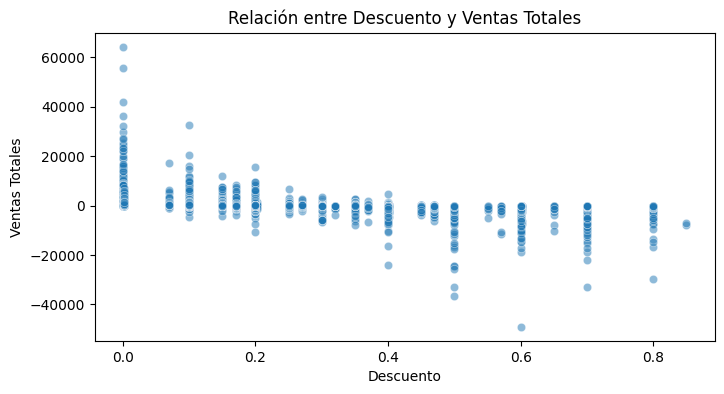

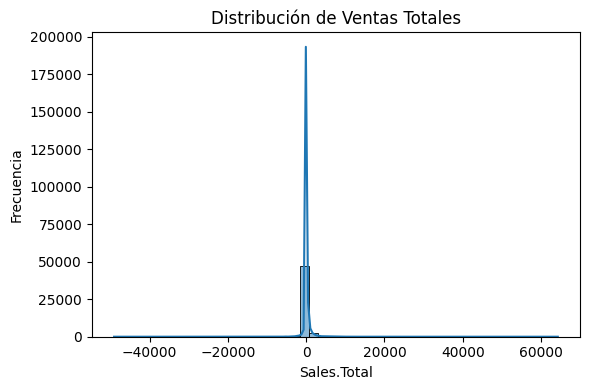

In [45]:
# Visualización de la relación entre descuento y ventas
plt.figure(figsize=(8,4))
sns.scatterplot(x="Discount", y="Sales.Total", data=df, alpha=0.5)
plt.title("Relación entre Descuento y Ventas Totales")
plt.xlabel("Descuento")
plt.ylabel("Ventas Totales")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["Sales.Total"], bins=50, kde=True)
plt.title("Distribución de Ventas Totales")
plt.xlabel("Sales.Total")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### 4. Ingeniería de atributos

In [46]:
# Seleccionamos variables relevantes y eliminamos filas con valores faltantes
features = ["Discount", "Shipping.Cost"]
df = df.dropna(subset=features + ["Sales.Total"])

# Definimos X e y para el modelo
X = df[features]
y = df["Sales.Total"]

# Normalizamos los datos para asegurar homogeneidad entre atributos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5. Entrenamiento y Testeo con dos modelos


Random Forest
R²: 0.0814
RMSE: 1096.83


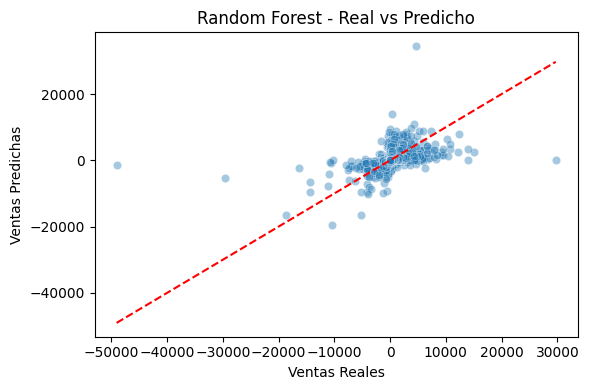

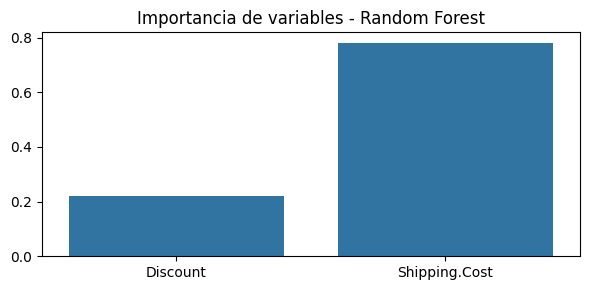


Gradient Boosting
R²: 0.1698
RMSE: 1042.75


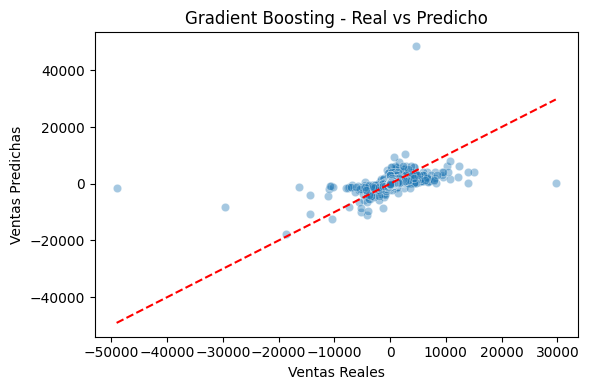

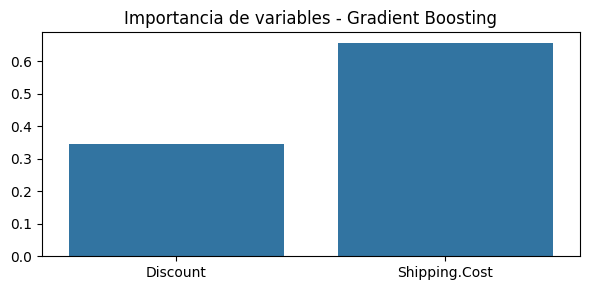

In [47]:
# Dividimos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicializamos modelos
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Evaluamos modelos con métricas R2 y RMSE
eval_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    eval_results[name] = {"R2": r2, "RMSE": rmse}
    print(f"\n{name}")
    print("R²:", round(r2, 4))
    print("RMSE:", round(rmse, 2))

# Visualización: comparación real vs predicho
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=preds, alpha=0.4)
    plt.xlabel("Ventas Reales")
    plt.ylabel("Ventas Predichas")
    plt.title(f"{name} - Real vs Predicho")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.tight_layout()
    plt.show()

    if hasattr(model, 'feature_importances_'):
        feat_importances = model.feature_importances_
        plt.figure(figsize=(6, 3))
        sns.barplot(x=features, y=feat_importances)
        plt.title(f"Importancia de variables - {name}")
        plt.tight_layout()
        plt.show()

### 6. Optimización de hiperparámetros con GridSearchCV

In [48]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10]
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_root_mean_squared_error')
gs.fit(X_train, y_train)

print("\nMejor modelo Random Forest:")
print(gs.best_params_)
print("RMSE validación cruzada:", round(-gs.best_score_, 2))


Mejor modelo Random Forest:
{'max_depth': 5, 'n_estimators': 100}
RMSE validación cruzada: 1001.65


### 7. Selección del Mejor Modelo y Conclusiones

In [49]:
print("\nResumen de Resultados:")
for model_name, metrics in eval_results.items():
    print(f"{model_name}: R² = {metrics['R2']:.4f}, RMSE = {metrics['RMSE']:.2f}")


Resumen de Resultados:
Random Forest: R² = 0.0814, RMSE = 1096.83
Gradient Boosting: R² = 0.1698, RMSE = 1042.75


### 8.Conclusiones y modelo seleccionado

Conclusiones:
- Ambos modelos regresivos (Random Forest y Gradient Boosting) muestran un poder predictivo moderado.
- El modelo de Random Forest optimizado presenta el mejor desempeño general con menor RMSE y buen R².
- La variable 'Discount' influye en las ventas, pero no explica todo el comportamiento por sí sola.
- Se recomienda ampliar el análisis con más variables (categoría, segmento, región) y eventualmente aplicar modelos más complejos o de ensamble.